In [1]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md
import numpy as np
import os

import MDAnalysis as mda
import nglview as nv

import pandas as pd

import itertools
import linecache
import glob

In [2]:
from manuscript import *
sns.set(style="ticks",context='paper',font_scale=2.5)

<Figure size 432x288 with 0 Axes>

In [3]:
from NACHRA7_annotations import *

In [4]:
ef_ion_dens_loc = ["".join(i) for i in itertools.product([default_load_location],
                   ['NACHRA7_NOPNU_EPJ_POPC_CAM/'],
                   ['/EF_200_5CA/', '/EF_200_0CA/','/EF_200_150CA/','/EF_200_150CA_0NA/'])]
reps = 4

In [5]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name', 'frame','traj_time','system', 'rep']))

In [6]:
def append_metadata(file_loc, rep, system):

    md_name = file_loc.split('/')[-2]
    top_location = file_loc + '/init.pdb'
    traj_location = f'{file_loc}/rep{rep}/ef.xtc'
    traj = mda.Universe(top_location,
                        traj_location)
    n_frames = traj.trajectory.n_frames
    time = traj.trajectory.n_frames * traj.trajectory.dt

    rep_data = [[md_name, n_frames, time, system, rep]]

    return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(file_loc = file_loc, 
                                                        rep = str(rep),
                                                        system = ind,
                                               )
                           for ind, file_loc in enumerate(ef_ion_dens_loc)
                           for rep in range(1, reps+1)
                           )

md_data = create_md_dataframe()
for i in range(0, len(meta_data)):
    md_data = pd.concat([md_data, pd.DataFrame(meta_data[i],columns=list(['MD_name', 'frame','traj_time','system', 'rep']))],ignore_index=True)
md_data['frame'] = md_data['frame'].apply(int)
md_data['traj_time'] = md_data['traj_time'].apply(float)
md_data['rep'] = md_data['rep'].apply(int)
md_data['system'] = md_data['system'].apply(int)

/nethome/yzhuang/git_repo/mdanalysis_dev/package/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nethome/yzhuang/git_repo/mdanalysis_dev/package/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nethome/yzhuang/git_repo/mdanalysis_dev/package/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nethome/yzhuang/git_repo/mdanalysis_dev/package/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element 

In [ ]:
def get_ion_density(file_loc, rep, system, ion_name):
    def cartesian_to_cylinder(posx, posy, princ_x, princ_y):
        return np.sqrt((posx - princ_x) ** 2 + (posy - princ_y) ** 2)

    md_name = file_loc.split('/')[-2]
#    return f'./ion_dens/{md_name}_{ion_name}_rep{rep}_pos.npy'

    top_location = file_loc + '/init.pdb'
    traj_location = f'{file_loc}/rep{rep}/ef.xtc'
    traj = mda.Universe(top_location,
                        traj_location)


    # get ion density
    if ion_name == 'CAM':
        ion = traj.select_atoms(f'resname {ion_name} and name D0 or resname CAL')
    else:
        ion = traj.select_atoms(f'resname {ion_name}')

    princ_center = np.mean(traj.select_atoms('resid 247 and name CA').positions[:5],axis=0)
    ion_data = np.zeros([len(traj.trajectory), ion.n_atoms, 4])
    for i, ts in enumerate(traj.trajectory):
        position_x = ion.positions.T[0]
        position_y = ion.positions.T[1]
        position_z = ion.positions.T[2] - princ_center[2]
        position_r = cartesian_to_cylinder(position_x, position_y, princ_center[0], princ_center[1])

        ion_data[i] = np.asarray([position_x,
                                   position_y,
                                   position_z,
                                   position_r]).T

    np.save(f'./ion_dens/{md_name}_{ion_name}_rep{rep}_pos.npy', ion_data)

    return f'./ion_dens/{md_name}_{ion_name}_rep{rep}_pos.npy'
    
for ion_name in ['SOD', 'CAM']:
    ion_data = Parallel(n_jobs=num_cores)(delayed(get_ion_density)(
                                                        file_loc = file_loc, 
                                                        rep = str(rep),
                                                        system = ind,
                                                        ion_name = ion_name,
                                               )
                           for ind, file_loc in enumerate(ef_ion_dens_loc)
                           for rep in range(1, reps+1)
                           )
    md_data['ion_pos_' + ion_name] = ion_data

In [ ]:
def get_ion_around_e44(file_loc, rep, system, ion_name):
    md_name = file_loc.split('/')[-2]

    top_location = file_loc + '/init.pdb'
    traj_location = f'{file_loc}/rep{rep}/ef.xtc'
    traj = mda.Universe(top_location,
                        traj_location)


    # get ion density
    if ion_name == 'CAM':
        ion = traj.select_atoms(f'(around 5 (resid 44 and protein)) and (resname {ion_name} and name D0 or resname CAL)', updating=True)
    else:
        ion = traj.select_atoms(f'(around 5 (resid 44 and protein)) and resname {ion_name}', updating=True)

    ion_data = np.zeros(len(traj.trajectory))
    for i, ts in enumerate(traj.trajectory):
        ion_data[i] = ion.n_atoms

    np.save(f'./ion_dens/{md_name}_{ion_name}_rep{rep}_naround44.npy', ion_data)

    return f'./ion_dens/{md_name}_{ion_name}_rep{rep}_naround44.npy'
    
for ion_name in ['SOD', 'CAM']:
    ion_data = Parallel(n_jobs=num_cores)(delayed(get_ion_around_e44)(
                                                        file_loc = file_loc, 
                                                        rep = str(rep),
                                                        system = ind,
                                                        ion_name = ion_name,
                                               )
                           for ind, file_loc in enumerate(ef_ion_dens_loc)
                           for rep in range(1, reps+1)
                           )
    md_data['ion_around44_' + ion_name] = ion_data

In [29]:
md_data.to_csv('./ion_dens/md_data.csv')

In [ ]:
md_data = pd.read_csv('./ion_dens/md_data.csv')

In [32]:
ion_pos = np.load('./ion_dens/EF_200_0CA_SOD_rep1_pos.npy')

In [36]:
from matplotlib.colors import LogNorm

ion_name_2ion = {'SOD': 'Sodium', 'CAM': 'Calcium'}

def plot_ion_dens(ion_pos,
                  ax,
                  ncontours=100,
                  levels=3,
                  vmin=None,
                  vmax=None,
                  cmap='GnBu'):

    nbins = [100, 50]
    zall = ion_pos.T[2]
    rall = ion_pos.T[3]

    # weighted by radius
    hist, zedge, redge = np.histogram2d(
        zall, rall, bins=nbins, range=[[-100, 100], [0, 100]], normed=True,
        weights=1.0 / rall)

    r = 0.5 * (zedge[:-1] + zedge[1:])
    z = 0.5 * (redge[:-1] + redge[1:])

    # pi = hist / (2 * pi * dr * dz) / (n_frames * n_ions)
#    pi = hist / (2 * np.pi * 2 * 2) / ion_pos.shape[0]
    pi = hist
    pi = np.ma.masked_where(pi <= 0, pi)

    norm = LogNorm(vmin=vmin, vmax=vmax)
    levels_contf = np.logspace(np.floor(np.log10(vmin)),
                         np.ceil(np.log10(vmax)), ncontours + 1)
    mappable = ax.contourf(
        z, r, pi, ncontours,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        norm=norm,
        extend='max',
        levels=levels_contf,
        )

    levels_cont = np.logspace(np.floor(np.log10(vmin)),
                         np.ceil(np.log10(vmax)), levels)

    contour = ax.contour(
        z, r, pi, 3,
        vmin=vmin,
        vmax=vmax,
        colors='black',
        norm=norm,
#        locator=FixedLocator(levels),
        extend='max',
        levels=levels_cont,
        linestyles='dashed'
        )

    return mappable



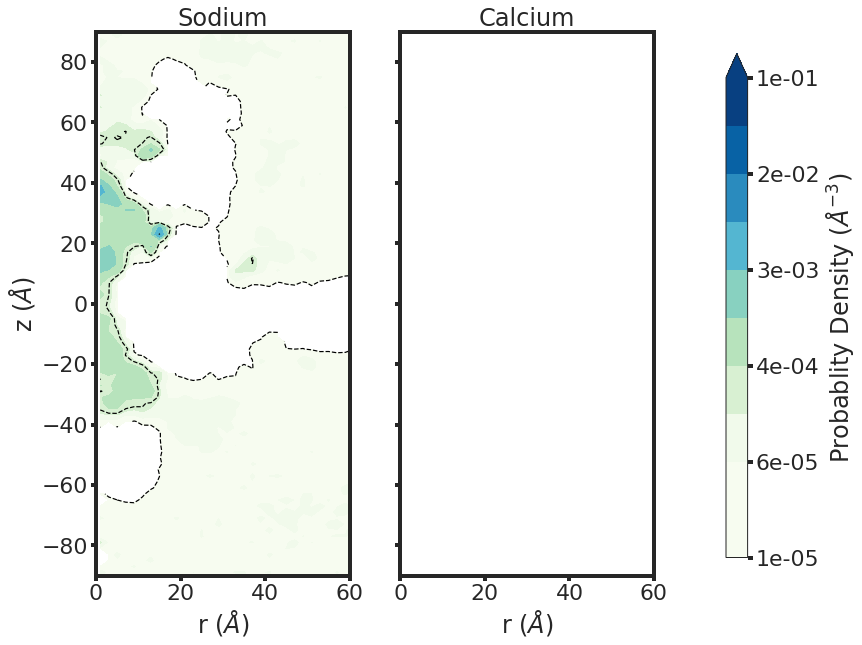

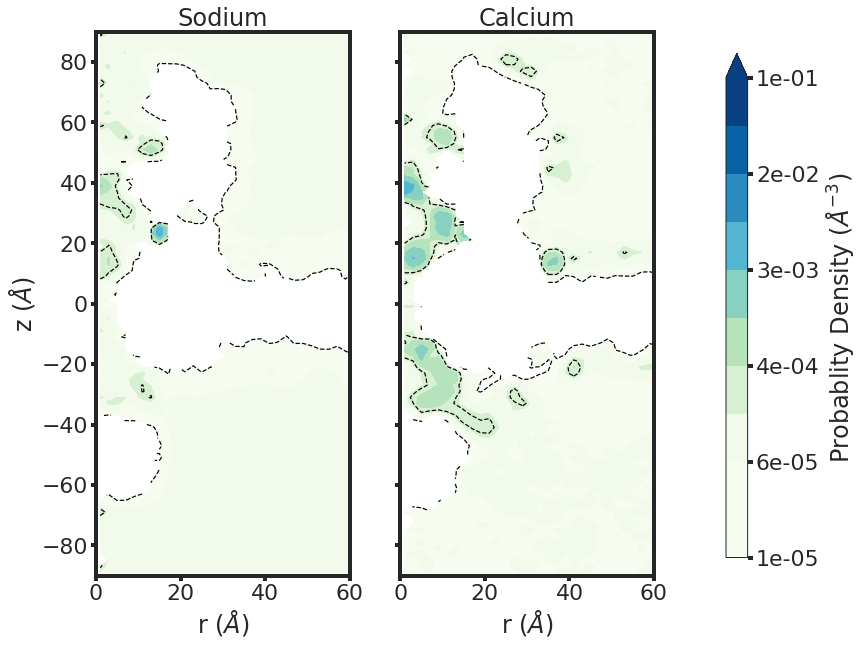

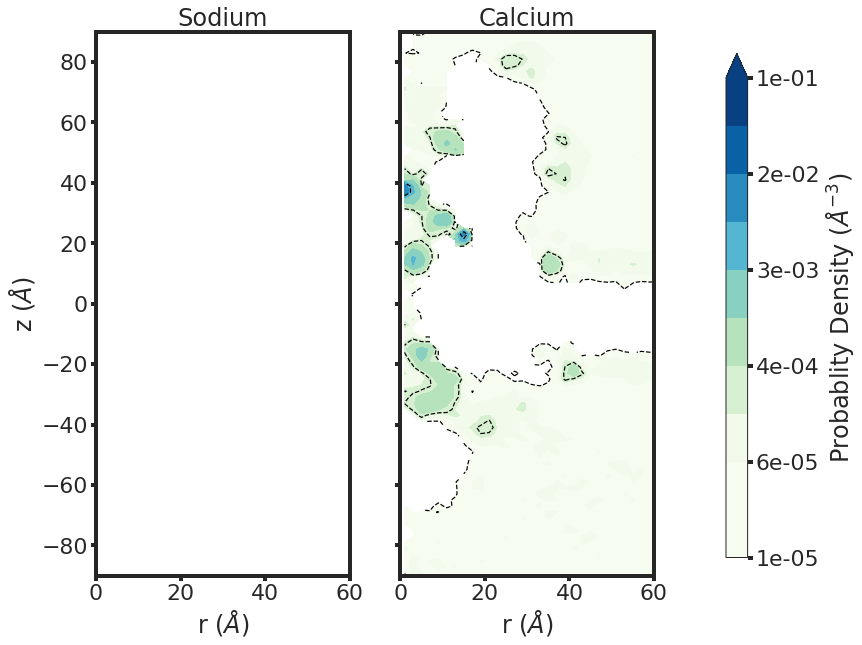

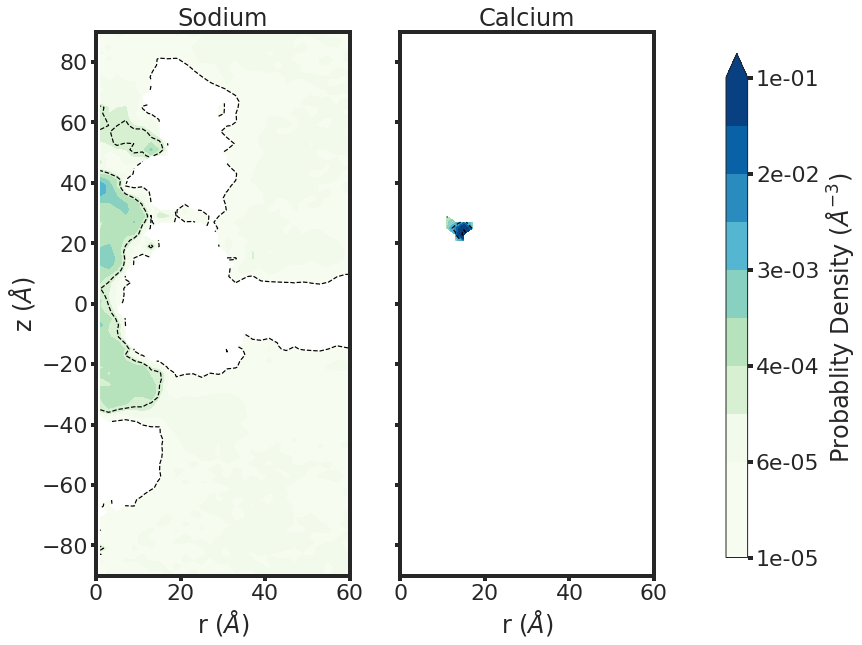

In [53]:
start_frame = -500
for md_name, df in md_data.groupby(['MD_name']):

    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
    for ion_name, ax in zip(['SOD', 'CAM'], axes):
        ion_pos = []
        for pos_loc in df['ion_pos_' + ion_name]:
            ion_pos.append(np.load(pos_loc)[start_frame:])
        ion_pos = np.concatenate(ion_pos, axis=0)
        if ion_pos.shape[1] != 0:
            ion_pos = np.concatenate(ion_pos, axis=0)
            mappable = plot_ion_dens(ion_pos,
                                    ax=ax,
                                    vmin=8e-5,
                                    vmax=5e-2,
                                    ncontours=10,
                                    levels=4)
        ax.set_xlim([0, 60])
        ax.set_ylim([-90,90])
        ax.set_xlabel(r'r ($\AA$)')
        ax.set_ylabel(r'z ($\AA$)')
        ax.set_title(ion_name_2ion[ion_name])

        set_axis_boarder(ax)

    axes[1].set_ylabel('')

    cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])

    cbar = fig.colorbar(mappable, cax=cbaxes, format='%.0e')
    cbar.set_label(r'Probablity Density ($\AA ^{-3}$)')
    set_axis_boarder(cbaxes)

    plt.savefig('ion_dens_' + md_name + 'last40.pdf',
                bbox_inches = 'tight',
                pad_inches=0.1,
                transparent=False)

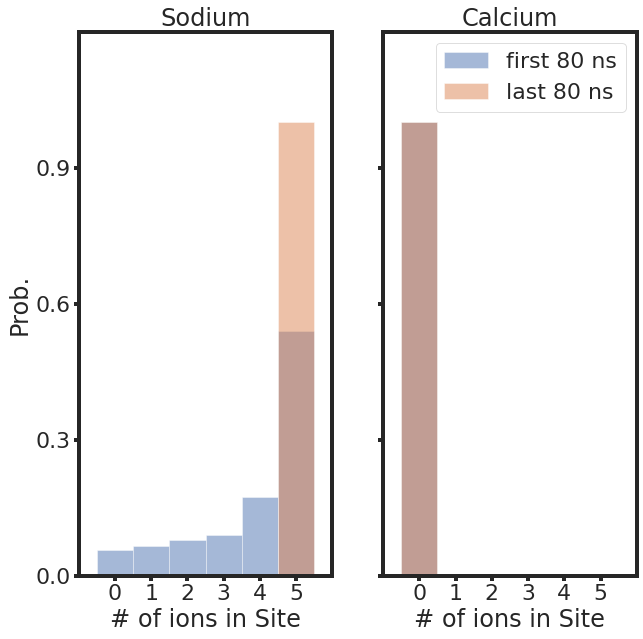

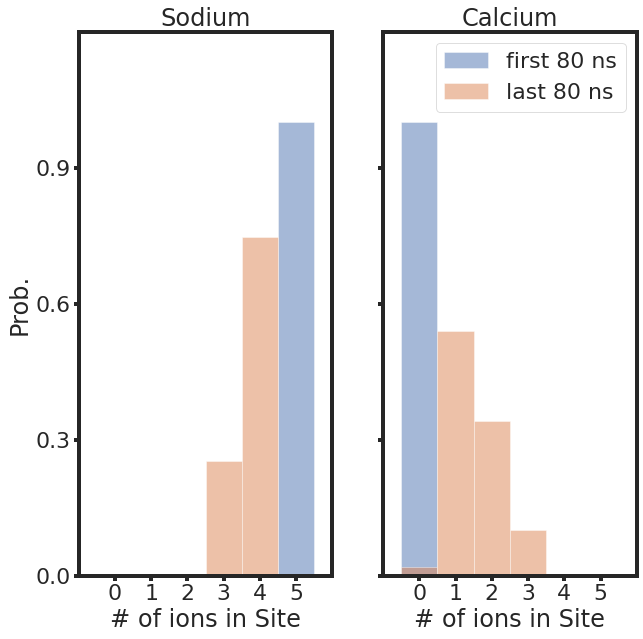

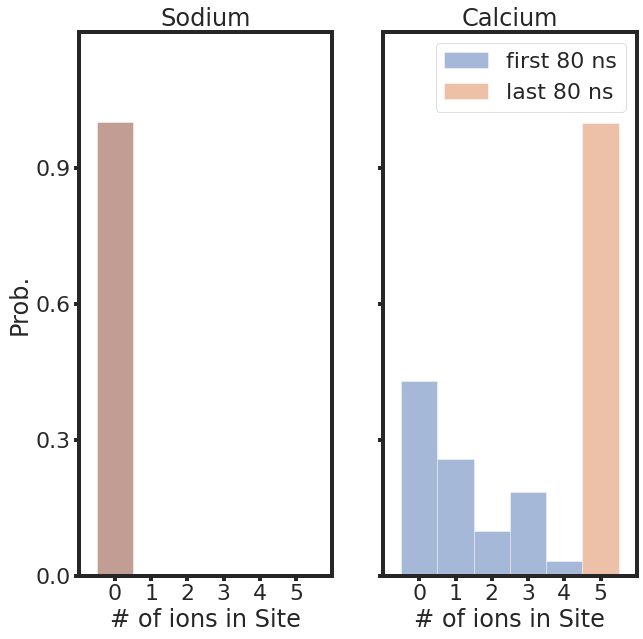

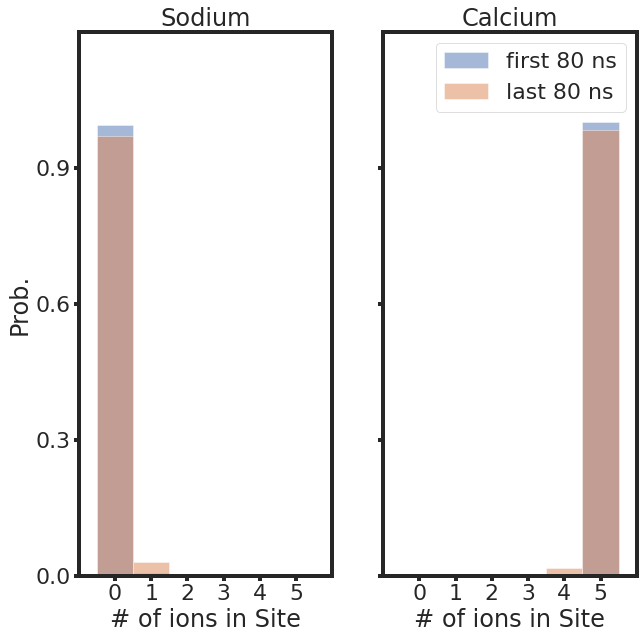

In [54]:
end_frame = 200
start_frame = -200
for md_name, df in md_data.groupby(['MD_name']):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
    for ion_name, ax in zip(['SOD', 'CAM'], axes):
        ion_pos = []
        for pos_loc in df['ion_around44_' + ion_name]:
            ion_pos.append(np.load(pos_loc)[:end_frame])
        ion_pos = np.concatenate(ion_pos, axis=0)

        ax.hist(ion_pos, bins=[0, 1, 2, 3, 4, 5, 6], density=True, stacked=True,
                alpha=0.5, align='left', label='first 80 ns')

        ion_pos = []
        for pos_loc in df['ion_around44_' + ion_name]:
            ion_pos.append(np.load(pos_loc)[start_frame:])
        ion_pos = np.concatenate(ion_pos, axis=0)

        ax.hist(ion_pos, bins=[0, 1, 2, 3, 4, 5, 6],  density=True, stacked=True,
                alpha=0.5, align='left', label='last 80 ns')

        ax.set_title(ion_name_2ion[ion_name])
        ax.set_xlim(-1,6)
        ax.set_ylim(0,1.2)

        ax.set_xlabel(r'# of ions in Site')
        ax.set_ylabel(r'Prob.')
        ax.set_xticks([0, 1, 2, 3, 4, 5])
        ax.set_yticks([0, 0.3, 0.6, 0.9])

        set_axis_boarder(ax)


    axes[1].set_ylabel('')
    axes[1].legend(loc=0)
    set_axis_boarder(cbaxes)

    plt.savefig('ion_around44_' + md_name + '.pdf',
                bbox_inches = 'tight',
                pad_inches=0.1,
                transparent=False)